<h1 style="text-align:center; color:MediumSlateBlue;">LeNet on CIFAR-10 dataset</h1>

<h3>Import libraries & packages</h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Lambda
from keras.layers import Conv2D, Activation, AveragePooling2D
from keras.models import Model
from keras.models import model_from_json
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


<h3>Load data</h3>

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def load_cifar10(data_path):

    train_data = None
    train_labels = []
    test_data = None
    test_labels = None


    for i in range(1, 6):
        data_dict = unpickle(data_path + "data_batch_" + str(i))
        if (i == 1):
            train_data = data_dict[b'data']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels += data_dict[b'labels']

    test_data_dict = unpickle(data_path + "test_batch")
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    train_data = train_data.reshape((50000, 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)
    
    test_data = test_data.reshape((10000, 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, test_data, test_labels

In [4]:
data_path = "../cifar-10-batches-py/"
train_data, train_labels, test_data, test_labels = load_cifar10(data_path)

In [5]:
print("train_data.shape:", train_data.shape, "train_labels.shape:", train_labels.shape)
print("test_data.shape:", test_data.shape, "test_labels.shape:", test_labels.shape)

train_data.shape: (50000, 32, 32, 3) train_labels.shape: (50000,)
test_data.shape: (10000, 32, 32, 3) test_labels.shape: (10000,)


Test

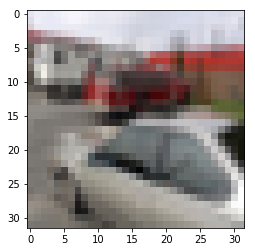

In [6]:
plt.imshow(train_data[-1])
plt.show()

<h3>Data preprocessing</h3>

In [7]:
def scale_data(data):
    """ 
    Scale the row pixel intensities to the range [0, 1]
    """
    data = data.astype(np.float32) / 255.0
    return data

train_data = scale_data(train_data)
test_data = scale_data(test_data)

In [8]:
def one_hot_labels(label_data):
    """
    One hot encode the labels
    """
    label_data = to_categorical(label_data, num_classes=10)
    
    return label_data

train_labels = one_hot_labels(train_labels)
test_labels = one_hot_labels(test_labels)

In [9]:
train_labels.shape, test_labels.shape

((50000, 10), (10000, 10))

<h3>Train/validation split</h3>

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, \
                                                      test_size=0.1, \
                                                      random_state=42)

print("X_train.shape:", X_train.shape, "y_train.shape", y_train.shape)
print("X_valid.shape:", X_valid.shape, "y_valid.shape", y_valid.shape)

X_train.shape: (45000, 32, 32, 3) y_train.shape (45000, 10)
X_valid.shape: (5000, 32, 32, 3) y_valid.shape (5000, 10)


<h3>Building LeNet model</h3>

In [11]:
def convert_gray(image):
    return tf.image.rgb_to_grayscale(image)

In [12]:
def LeNet_model(input_shape, num_classes):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=input_shape, name="Input")
    
    X = Lambda(convert_gray, input_shape=(32, 32, 3), output_shape=(32, 32, 1), name="Grayscale")(X_input)
    
    # 1st CONV LAYER: # filters->6; filter size->(5, 5); no pad;  
    X = Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), \
               kernel_initializer=glorot_uniform(seed=0), \
               padding="valid", \
               name="Conv_1")(X)
    # Add non linearity activation function with Rectified Linear Unit (ReLU)
    X = Activation("tanh", name="Tanh_1")(X)
    # Average Pooling Layer
    X = AveragePooling2D(pool_size=(2, 2), name="AvgPool_1")(X)
    
    # 2nd CONV LAYER: #filters->16; filter size->(5, 5); no pad
    X = Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), \
               kernel_initializer=glorot_uniform(seed=0), \
               padding="valid", \
               name="Conv_2")(X)
    X = Activation("tanh", name="Tanh_2")(X)
    X = AveragePooling2D(pool_size=(2, 2), name="AvgPool_2")(X)
    
    # 3rd CONV LAYER: #filters->120; filter size->(5, 5); no pad
    X = Conv2D(filters=120, kernel_size=(5, 5), strides=(1, 1), \
               kernel_initializer=glorot_uniform(seed=0), \
               padding="valid", \
               name="Conv_3")(X)
    X = Activation("tanh", name="Tanh_3")(X)
    # Flatten
    X = Flatten(name="Flatten")(X)
    
    # 1st Fully Connected layer (FC)
    X = Dense(84, name="FC_1")(X)
    X = Activation("tanh", name="Tanh_4")(X)
    
    # Output with Gaussian connections
    X = Dense(num_classes, name="FC_2")(X)

    def gaussian(x):
        return K.exp(-K.pow(x, 2))
    
    X = Activation(gaussian, name="rbf")(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name="LeNet")
    
    return model

In [13]:
model = LeNet_model(input_shape=(32, 32, 3), num_classes= y_train.shape[-1])

We can take a peek at the overall structure we just made by calling the method <i>summary()</i>:

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Grayscale (Lambda)           (None, 32, 32, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
Tanh_1 (Activation)          (None, 28, 28, 6)         0         
_________________________________________________________________
AvgPool_1 (AveragePooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 10, 10, 16)        2416      
_________________________________________________________________
Tanh_2 (Activation)          (None, 10, 10, 16)        0         
__________

<h3>Compile Model</h3>

In [28]:
adam = Adam(lr=1e-4)

model.compile(optimizer=adam, \
              loss='categorical_crossentropy', \
              metrics=['accuracy'])

<h3>Create checkpoint</h3>

In [29]:
filepath = "./checkpoint/weights_best_lenet.hdf5"
checkpoint = ModelCheckpoint(filepath, \
                             monitor="val_acc", \
                             verbose=0, \
                             save_best_only=True, \
                             mode="max")
callbacks_list = [checkpoint]

<h3>Fit the model</h3>

In [30]:
history = model.fit(X_train, y_train, \
                    validation_data=(X_valid, y_valid), \
                    epochs=100, \
                    batch_size=128, \
                    callbacks=callbacks_list, \
                    verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 30s 656us/step - loss: 2.1657 - acc: 0.1954 - val_loss: 2.1224 - val_acc: 0.2304
Epoch 2/100
45000/45000 [==============================] - 30s 659us/step - loss: 2.0773 - acc: 0.2622 - val_loss: 2.0894 - val_acc: 0.2580
Epoch 3/100
45000/45000 [==============================] - 29s 638us/step - loss: 2.0565 - acc: 0.2700 - val_loss: 2.0556 - val_acc: 0.2732
Epoch 4/100
45000/45000 [==============================] - 29s 644us/step - loss: 2.0378 - acc: 0.2792 - val_loss: 2.0517 - val_acc: 0.2578
Epoch 5/100
45000/45000 [==============================] - 29s 641us/step - loss: 2.0172 - acc: 0.2870 - val_loss: 2.0232 - val_acc: 0.2830
Epoch 6/100
45000/45000 [==============================] - 29s 638us/step - loss: 1.9917 - acc: 0.2974 - val_loss: 2.0022 - val_acc: 0.2864
Epoch 7/100
45000/45000 [==============================] - 29s 646us/step - loss: 1.9635 - acc: 0.3064 - val_lo

Epoch 59/100
45000/45000 [==============================] - 28s 618us/step - loss: 1.4592 - acc: 0.4846 - val_loss: 1.5584 - val_acc: 0.4516
Epoch 60/100
45000/45000 [==============================] - 28s 623us/step - loss: 1.4524 - acc: 0.4856 - val_loss: 1.5903 - val_acc: 0.4468
Epoch 61/100
45000/45000 [==============================] - 28s 618us/step - loss: 1.4494 - acc: 0.4865 - val_loss: 1.5601 - val_acc: 0.4476
Epoch 62/100
45000/45000 [==============================] - 28s 622us/step - loss: 1.4453 - acc: 0.4880 - val_loss: 1.5494 - val_acc: 0.4546
Epoch 63/100
45000/45000 [==============================] - 28s 620us/step - loss: 1.4445 - acc: 0.4907 - val_loss: 1.5520 - val_acc: 0.4520
Epoch 64/100
45000/45000 [==============================] - 28s 621us/step - loss: 1.4372 - acc: 0.4901 - val_loss: 1.5594 - val_acc: 0.4460
Epoch 65/100
45000/45000 [==============================] - 28s 623us/step - loss: 1.4328 - acc: 0.4945 - val_loss: 1.5523 - val_acc: 0.4570
Epoch 66/100


<h3>Load weights of trained model</h3>

In [16]:
model.load_weights("./checkpoint/weights_best_lenet.hdf5")

<h3>Compile model (required to make predictions)</h3>

In [17]:
adam = Adam(lr=1e-4)

model.compile(optimizer=adam, \
              loss='categorical_crossentropy', \
              metrics=['accuracy'])

<h3>Estimate accuracy on test set</h3>

In [18]:
X_test, y_test = test_data, test_labels
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 7s 690us/step
acc: 47.92%
